# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import io

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt

import seaborn as sns
import gensim
from gensim.models import FastText

# Đọc dữ liệu

In [2]:
# read dataset
df = pd.read_excel('nckh_2023.xlsx')

In [84]:
df.describe()

,Content,Conclusion
count,1795,1795
unique,1638,2
top,20/11 trường mình có cho nghỉ không ạ,No
freq,5,989


In [65]:
# hiển thị dataset
df.head()

,Content,Conclusion
0,Dạ ac cho e hỏi là e là SV năm nhất nhưng em đ...,Yes
1,Đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,Cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
3,Tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
4,Cho e hỏi nên học tiếng anh ở trường k ạ,Yes


In [12]:
df['Conclusion'].value_counts()

Conclusion
No     989
Yes    806
Name: count, dtype: int64

In [13]:
len(df),df.index.shape[-1]

(1797, 1797)

In [14]:
## Assess the shape of the data
print("The Shape of the Dataset".format(),df.shape)

The Shape of the Dataset (1797, 2)


# Phân tích thống kê

In [16]:
# Đưa ra danh sách các loại nhãn:
unique_labels : np.ndarray = df["Labels"].unique()
# unique_labels.sort()
print(unique_labels)

['Positive' 'Negative' 'Neutral' 'Positive ' 'positive']


In [7]:

# Xử lý nhãn sử dụng hàm apply
handle_labels = df["Labels"].apply(
    lambda label: label if label in unique_labels[0:3] else unique_labels[2])
df = df.drop(columns="Labels")
df["Labels"] = handle_labels

In [8]:
df.describe()

,Reviews,Labels
count,2662,2662
unique,2543,3
top,Trường đào tạo giao thông đầu ngành của Việt N...,Positive
freq,4,1169


In [10]:
# Hiển thị review 
df['Reviews'][0]

'khuôn viên rộng rãi, khang trang, sạch sẽ, mở trường hoà đồng, vui vẻ, đào tạo ok, học phí rẻ ,...ok.'

In [11]:
pos_reviews=df[df['Labels']=='Positive']['Reviews']
neg_reviews=df[df['Labels']=='Negative']['Reviews']
neu_reviews = df[df['Labels']=='Neutral']['Reviews']
print("First 10 samples of positive reviews\n".format(),pos_reviews[:10])
print("First 10 samples of negative reviews\n".format(),neg_reviews[:10])
print("First 10 samples of neutral reviews\n".format(),neu_reviews[:10])


First 10 samples of positive reviews
 0     khuôn viên rộng rãi, khang trang, sạch sẽ, mở ...
3              Đại học Giao thông vận tải là tuyệt đỉnh
4                     Nhiều anh sinh viên đẹp trai :(((
5     Từ giờ hãy gọi UTC là Đại học Thể dục Thể thao...
6                               nhiều trai xinh gái đẹp
8     Nhờ xem clip mới biết trường mình nhiều nữ đến...
11    Ktx trường mình khá ổn. Có phònó nóng lạnh vs ...
13    Ở ký túc vui lắm các bạn\nTôi hay sang ký túc ...
17                       Sẽ rất tuyệt vời hôm nào mưa .
18                                         được em ah !
Name: Reviews, dtype: object
First 10 samples of negative reviews
 1     Kính gửi ông hiệu trưởng cùng các bạn s...
9     hahaha gtvt vô đó là ế nha. đừng tiếp bước tôi...
10    Có mỗi cái mạng thôi, ngày nào cũng phải năn n...
12            Câu Lạc Bộ của Đáy Xã Hội bạn tham gia ko
14                      Ktx đối lập với trường luôm :vv
15                    Ở nửa tháng 1tr tiền điện nhé:)))

In [12]:
#Count of positive, negative, neutral reviews
count=df['Labels'].value_counts()
print('Total Counts of both sets\n'.format(),count)

Total Counts of both sets
 Positive    1169
Neutral      882
Negative     611
Name: Labels, dtype: int64


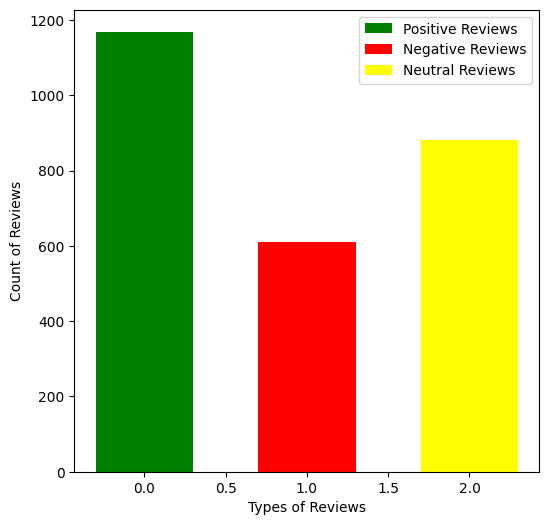

In [13]:
print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_pos,count_neg,count_neu):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_pos,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(1,count_neg,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.bar(2,count_neu,width=0.6,label='Neutral Reviews',color='Yellow')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()
    
count_pos=df[df['Labels']=='Positive']
count_neg=df[df['Labels']=='Negative']
count_neu=df[df['Labels']=='Neutral']
plot_counts(len(count_pos),len(count_neg),len(count_neu))

# Cleaning data

Xử lí căn bản

In [3]:
# Chuyển về chữ in thường
# Áp dụng phương thức lower() chỉ cho các giá trị là chuỗi
df['Content'] = df['Content'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df.head()


,Content,Conclusion
0,dạ ac cho e hỏi là e là sv năm nhất nhưng em đ...,Yes
1,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
3,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
4,cho e hỏi nên học tiếng anh ở trường k ạ,Yes


In [4]:
# Hàm của pandas, hiển thị số hàng trùng nhau
df.duplicated().sum()

143

In [5]:
# loại bỏ hàng trùng nhau
df = df.drop_duplicates()

In [6]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(df['Content'].fillna('').values)
# Remove URLs, mentions, and hashtags from the text
all_text = re.sub(r'httpsS+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)

In [7]:
df.head()

,Content,Conclusion
0,dạ ac cho e hỏi là e là sv năm nhất nhưng em đ...,Yes
1,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
3,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
4,cho e hỏi nên học tiếng anh ở trường k ạ,Yes


Bỏ dấu câu

In [8]:
# dấu câu
import string

In [9]:
# Hiển thị một vài dấu câu
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
# Hàm bỏ dấu câu
def remove_puctuation(text):
    if isinstance(text, str):
        for i in string.punctuation:
            if i in text:
                text = text.replace(i,' ')
            
    return text

In [11]:
df['Content'] = df['Content'].apply(remove_puctuation)

In [12]:
df.head()

,Content,Conclusion
0,dạ ac cho e hỏi là e là sv năm nhất nhưng em đ...,Yes
1,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
3,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
4,cho e hỏi nên học tiếng anh ở trường k ạ,Yes


Xoá bỏ Emoji

In [13]:
import re
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

df['Content'] = df['Content'].apply(lambda x: remove_emoji(str(x)))



In [14]:
df.head()

,Content,Conclusion
0,dạ ac cho e hỏi là e là sv năm nhất nhưng em đ...,Yes
1,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
3,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
4,cho e hỏi nên học tiếng anh ở trường k ạ,Yes


Loại bỏ khoảng trắng thừa

In [15]:
# Chuyển kiểu dữ liệu sang chuỗi
df['Content'] = df['Content'].astype(str)

# Điền giá trị NaN vào các ô dữ liệu bị thiếu
df['Content'] = df['Content'].fillna('')

# Áp dụng hàm loại bỏ khoảng trắng thừa vào cột 'Ten'
df['Content'] = df['Content'].apply(lambda x: re.sub('\s+', ' ', x).strip())

In [16]:
df.head()

,Content,Conclusion
0,dạ ac cho e hỏi là e là sv năm nhất nhưng em đ...,Yes
1,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
3,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
4,cho e hỏi nên học tiếng anh ở trường k ạ,Yes


Thay thế các từ viết tắt

In [17]:
import re
# đến dòng 90
def remove_abb(data):
    data = re.sub(r"\bsv\b", "sinh viên", data)
    data = re.sub(r"\bcc\b", "chứng chỉ", data)
    data = re.sub(r"\bac\b", "anh chị", data)    
    data = re.sub(r"\be\b", "em", data)   
    data = re.sub(r"\bđc\b", "được", data)  
    data = re.sub(r"\bdc\b", "được", data) 
    data = re.sub(r"\bhk\b", "học", data)   
    data = re.sub(r"\bk\b", "không", data)   
    data = re.sub(r"\bko\b", "không", data)
    data = re.sub(r"\bms\b", "mới", data)  
    data = re.sub(r"\bđko\b", "đúng không", data) 
    data = re.sub(r"\binf\b", "thông tin", data) 
    data = re.sub(r"\bcute\b", "dễ thương", data)
    data = re.sub(r"\bcuti\b", "dễ thương", data)
    data = re.sub(r"\bgr\b", "nhóm", data)           
    data = re.sub(r"\bclb\b", "câu lạc bộ", data)   
    data = re.sub(r"\btvien\b", "thành viên", data)   
    data = re.sub(r"\btgia\b", "tham gia", data)  
    data = re.sub(r"\bbt\b", "biết", data)    
    data = re.sub(r"\bktx\b", "kí túc xá", data)   
    data = re.sub(r"\bkh\b", "không", data)
    data = re.sub(r"\bin4\b", "thông tin", data)
    data = re.sub(r"\bmk\b", "mình", data)
    data = re.sub(r"\bbhyt\b", "bảo hiểm y tế", data)
    data = re.sub(r"\bchj\b", "chị", data)
    data = re.sub(r"\bqte\b", "quốc tế", data)
    data = re.sub(r"\bttnt\b", "trí tuệ nhân tạo", data)
    data = re.sub(r"\bacj\b", "anh chị", data)
    data = re.sub(r"\bshare\b", "chia sẻ", data)
    data = re.sub(r"\bkt\b", "kinh tế", data)
    data = re.sub(r"\bch\b", "chưa", data)
    data = re.sub(r"\br\b", "rồi", data)
    data = re.sub(r"\bcntt\b", "công nghệ thông tin", data)
    data = re.sub(r"\bm\b", "mình", data)
    data = re.sub(r"\bnvqs\b", "nghĩa vụ quân sự", data)
    data = re.sub(r"\bhssv\b", "học sinh sinh viên", data)
    data = re.sub(r"\bhsv\b", "hội sinh viên", data)
    data = re.sub(r"\bkhum\b", "không", data)
    data = re.sub(r"\binfo\b", "thông tin", data)
    data = re.sub(r"\bktvt\b", "kinh tế vận tải", data)
    data = re.sub(r"\bvp\b", "văn phòng", data)
    data = re.sub(r"\btrg\b", "trường", data)
    data = re.sub(r"\bbh\b", "bây giờ", data)
    data = re.sub(r"\bh\b", "giờ", data)
    data = re.sub(r"\bntn\b", "như thế nào", data)
    data = re.sub(r"\bntnao\b", "như thế nào", data)
    data = re.sub(r"\bđki\b", "đăng kí", data)
    data = re.sub(r"\bcf\b", "cà phê", data)
    data = re.sub(r"\bny\b", "người yêu", data)
    data = re.sub(r"\bmng\b", "mọi người", data)
    data = re.sub(r"\btsv\b", "tân sinh viên", data)
    data = re.sub(r"\bsvien\b", "sinh viên", data)
    data = re.sub(r"\bmn\b", "mọi người", data)
    data = re.sub(r"\bz\b", "vậy", data)
    data = re.sub(r"\bvs\b", "với", data)
    data = re.sub(r"\baddfr\b", "kết bạn", data)
    data = re.sub(r"\bvđe\b", "vấn đề", data)
    data = re.sub(r"\bj\b", "gì", data)
    data = re.sub(r"\bshcd\b", "sinh hoạt công dân", data)
    data = re.sub(r"\bcttt\b", "chương trình tiên tiến", data)
    data = re.sub(r"\bhphi\b", "học phí", data)
    data = re.sub(r"\binfor\b", "thông tin", data)
    data = re.sub(r"\bdk\b", "đăng ký", data)
    data = re.sub(r"\bdki\b", "đăng ký", data)
    data = re.sub(r"\bcsgt\b", "cảnh sát giao thông", data)
    data = re.sub(r"\bqp\b", "quốc phòng", data)
    data = re.sub(r"\btb\b", "trung bình", data)
    data = re.sub(r"\bj\b", "gì", data)
    data = re.sub(r"\bnckh\b", "nguyên cứu khoa học", data)
    data = re.sub(r"\bbnh\b", "bao nhiêu", data)
    data = re.sub(r"\bko\b", "không", data)
    data = re.sub(r"\bbhyt\b", "bảo hiểm y tế", data)
    data = re.sub(r"\bgtvt\b", "giao thông vận tải", data)
    data = re.sub(r"\bh\b", "giờ", data)
    data = re.sub(r"\bcty\b", "công ty", data)
    data = re.sub(r"\bb\b", "bạn", data)
    data = re.sub(r"\bv\b", "bảo vệ", data)
    data = re.sub(r"\bsđt\b", "số điện thoại", data)
    data = re.sub(r"\bmn\b", "mọi người", data)
    data = re.sub(r"\bmng\b", "mọi người", data)
    data = re.sub(r"\bvs\b", "với", data)
    data = re.sub(r"\blh\b", "liên hệ", data)
    data = re.sub(r"\btp\b", "thành phần", data)
    data = re.sub(r"\btacn\b", "tiếng anh chuyên ngành", data)
    data = re.sub(r"\bmsv\b", "mã sinh viên", data)
    data = re.sub(r"\bta\b", "tiếng anh", data)
    data = re.sub(r"\bclb\b", "câu lạc bộ", data)
    data = re.sub(r"\bzai\b", "trai", data)
    data = re.sub(r"\bbn\b", "bạn", data)
    data = re.sub(r"\bkh\b", "không", data)
    data = re.sub(r"\bmk\b", "mình", data)
    data = re.sub(r"\bhb\b", "học bổng", data)
    data = re.sub(r"\btsv\b", "tân sinh viên", data)
    data = re.sub(r"\bctdl&gt\b", "cấu trúc dữ liệu và giải thuật", data)
    data = re.sub(r"\bđeos\b", "đéo", data)
    data = re.sub(r"\bglvv\b", "giao lưu vui vẻ", data)
    data = re.sub(r"\btrick\b", "mẹo", data)
    data = re.sub(r"\bcamon\b", "cảm ơn", data)
    data = re.sub(r"\bmjk\b", "mình", data)
    data = re.sub(r"\bmk\b", "mình", data)
    data = re.sub(r"\bdki\b", "dăng ký", data)
    data = re.sub(r"\bbhyt\b", "bảo hiểm y tế", data)
    data = re.sub(r"\bb\b", "bạn", data)
    data = re.sub(r"\bvv\b", "vui vẻ", data)
    data = re.sub(r"\bko\b", "không", data)
    data = re.sub(r"\bk\b", "không", data)
    data = re.sub(r"\bkh\b", "không", data)
    data = re.sub(r"\bbtl\b", "bài tập lớn", data)
    data = re.sub(r"\bnlm\b", "nguyên lý mạch", data)
    data = re.sub(r"\bmng\b", "mọi người", data)
    data = re.sub(r"\bor\b", "hoặc", data)
    data = re.sub(r"\bof\b", "của", data)
    data = re.sub(r"\bhk\b", "học", data)
    data = re.sub(r"\bds\b", "danh sách", data)
    data = re.sub(r"\bmsv\b", "mã sinh viên", data)
    data = re.sub(r"\bstđ\b", "số điện thoại", data)
    data = re.sub(r"\btìn\b", "tìm", data)
    data = re.sub(r"\bak\b", "à", data)
    data = re.sub(r"\bbn\b", "bạn", data)
    data = re.sub(r"\bnyc\b", "người yêu cũ", data)
    data = re.sub(r"\bntn\b", "như thế nào", data)
    data = re.sub(r"\bng\b", "người", data)
    data = re.sub(r"\bsp\b", "giúp đỡ", data)
    data = re.sub(r"\btn\b", "thế nào", data)
    data = re.sub(r"\bbn\b", "bao nhiêu", data)
    data = re.sub(r"\bonl\b", "trực tuyến", data)
    data = re.sub(r"\bnc\b", "nước", data)
    data = re.sub(r"\bm\b", "mình", data)
    data = re.sub(r"\bktn\b", "kỹ thuật nhiệt", data)
    data = re.sub(r"\bgts\b", "giải tích số", data)
    data = re.sub(r"\bktx\b", "ký túc xá", data)
    data = re.sub(r"\bvid\b", "video", data)
    data = re.sub(r"\brecommed\b", "gợi ý", data)
    data = re.sub(r"\bvt\b", "vé tháng", data)
    data = re.sub(r"\bdc\b", "được", data)
    data = re.sub(r"\bmng\b", "mọi người", data)
    data = re.sub(r"\btby\b", "trung bình yếu", data)
    data = re.sub(r"\bng\b", "người", data)
    data = re.sub(r"\bak\b", "à", data)
    data = re.sub(r"\bny\b", "người yêu", data)
    data = re.sub(r"\bj\b", "gì", data)
    data = re.sub(r"\bđag\b", "đang", data)
    data = re.sub(r"\bko\b", "không", data)
    data = re.sub(r"\bmk\b", "mình", data)
    data = re.sub(r"\be\b", "em", data)
    data = re.sub(r"\biu\b", "yêu", data)
    data = re.sub(r"\bb\b", "bạn", data)
    data = re.sub(r"\bad\b", "admin", data)
    data = re.sub(r"\bng\b", "người", data)
    data = re.sub(r"\bhh\b", "học hộ", data)
    data = re.sub(r"\bcnxh\b", "chủ nghĩa xã hội", data)
    data = re.sub(r"\bbhyt\b", "bảo hiểm y tế", data)
    data = re.sub(r"\bbt\b", "biết", data)
    data = re.sub(r"\bib\b", "inbox", data)
    data = re.sub(r"\bin4\b", "info", data)
    data = re.sub(r"\bktx\b", "kí túc xá", data)
    data = re.sub(r"\bny\b", "người yêu", data)
    data = re.sub(r"\bvc\b", "việc", data)
    data = re.sub(r"\btrg\b", "trường", data)
    data = re.sub(r"\bfb\b", "facebook", data)
    data = re.sub(r"\bmn\b", "mọi người", data)
    data = re.sub(r"\bib\b", "inbox", data)
    data = re.sub(r"\bqldt\b", "quản lý đào tạo", data)
    data = re.sub(r"\bk\b", "không", data)
    data = re.sub(r"\bđc\b", "được", data)
    data = re.sub(r"\bak\b", "ạ", data)
    data = re.sub(r"\bm\b", "mình", data)
    data = re.sub(r"\banqp\b", "an ninh quốc phòng", data)
    data = re.sub(r"\bgdtc\b", "giáo dục thể chất", data)
    data = re.sub(r"\bbb\b", "bạn bè", data)
    data = re.sub(r"\ba.c\b", "anh chị", data)
    data = re.sub(r"\bng\b", "người", data)
    data = re.sub(r"\bđhgtvt\b", "đại học giao thông vận tải", data)
    
    return data

# Áp dụng hàm cho cột 'Content' trong DataFrame
df['Content'] = df['Content'].apply(remove_abb)

# In ra vài dòng đầu của DataFrame để kiểm tra kết quả
df.head()


,Content,Conclusion
0,dạ anh chị cho em hỏi là em là sinh viên năm n...,Yes
1,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
2,cho em hỏi đi học quân sự là học tại trường 1 ...,Yes
3,tuy mờ vaio nhưng mà vẫn muốn xin thông tin bạ...,No
4,cho em hỏi nên học tiếng anh ở trường không ạ,Yes


# Lưu vào một file mới

In [18]:

from openpyxl import Workbook
# Specify the path to the Excel file
excel_file_path = 'C:/Users/Admin/Desktop/NCKH/Code/dataset_f.xlsx'

# Use ExcelWriter to write the DataFrame to Excel
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    # Write the DataFrame to the Excel file
    df.to_excel(writer, index=False, sheet_name='Sheet1')

# Confirm the write was successful
print(f"DataFrame has been written to {excel_file_path}")

DataFrame has been written to C:/Users/Admin/Desktop/NCKH/Code/dataset_f.xlsx


# Tokenize và xoá từ dừng

## Tokenize

In [3]:
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
import py_vncorenlp
py_vncorenlp.download_model(save_dir='C:\\Users\\Admin\\Desktop\\NCKH\\VnCoreNLP\\VnCoreNLP-1.2')

VnCoreNLP model folder C:\Users\Admin\Desktop\NCKH\VnCoreNLP\VnCoreNLP-1.2 already exists! Please load VnCoreNLP from this folder!


In [4]:
model = py_vncorenlp.VnCoreNLP(save_dir='C:\\Users\\Admin\\Desktop\\NCKH\\VnCoreNLP\\VnCoreNLP-1.2')

In [22]:
import pandas as pd
from pyvi import ViTokenizer  # Thư viện phân đoạn tiếng Việt

# Đường dẫn đến file Excel đầu vào
file_path = r'C:\Users\Admin\Desktop\NCKH\Code\dataset_f.xlsx'

# Đọc dữ liệu từ file Excel
data = pd.read_excel(file_path)

# Kiểm tra và xử lý giá trị NaN trong cột cần xử lý
data['Content'] = data['Content'].fillna('')  # Thay NaN bằng chuỗi rỗng

# Chuyển cột cần xử lý sang kiểu chuỗi
data['Content'] = data['Content'].astype(str)

# Phân đoạn và tạo cột mới chứa kết quả
data['Content'] = data['Content'].apply(lambda x: ViTokenizer.tokenize(x))

# Lưu kết quả vào file Excel mới
output_file = r'C:\Users\Admin\Desktop\NCKH\Code\output_dataset_f.xlsx'
data.to_excel(output_file, index=False)

In [5]:
text = "Trường đại học giao thông vận tải là một trong những trường top kỹ thuật hàng đầu Việt Nam"
output = model.word_segment(text)
print(output)
# ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

['Trường đại_học giao_thông vận_tải là một trong những trường top kỹ_thuật hàng_đầu Việt_Nam']


## Xoá từ dừng

In [26]:
import requests

url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
r = requests.get(url)

stopwords = r.text.split('\n')


In [27]:
from pyvi import ViTokenizer, ViPosTagger


In [30]:
df = pd.read_excel(r'C:\Users\Admin\Desktop\NCKH\Code\output_dataset_f.xlsx')

In [33]:
from pyvi import ViTokenizer

# Hàm kiểm tra và xử lý giá trị không mong muốn
def process_value(value):
    if isinstance(value, float):
        return str(value)
    return value

# Áp dụng hàm process_value cho cột 'Content'
df['Content'] = df['Content'].apply(process_value)

# Hàm remove_stopwords đã cải tiến
def remove_stopwords(review):
    try:
        words = ViTokenizer.tokenize(review).split()
        filtered_words = [word for word in words if word not in stopwords]
        return ' '.join(filtered_words)
    except Exception as e:
        print(f"Error processing text: {review}, Error: {e}")
        return ''

# Áp dụng hàm remove_stopwords cho cột 'Content'
df['Content'] = df['Content'].apply(remove_stopwords)


In [34]:
df.head()

,Content,Conclusion
0,anh_chị sinh_viên kém bộ_môn tiếng học thi chứ...,Yes
1,đêm mong_nhớ xong lỡ trao trái_tim tha_thiết t...,No
2,đi học quân_sự học trường 1,Yes
3,mờ vaio thông_tin nữ đứng chiều hôm_qua tòa a7...,No
4,học tiếng trường,Yes


In [35]:

from openpyxl import Workbook
# Specify the path to the Excel file
excel_file_path = 'C:/Users/Admin/Desktop/NCKH/Code/dataset_f_tokenize_remove_stoppedword.xlsx'

# Use ExcelWriter to write the DataFrame to Excel
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    # Write the DataFrame to the Excel file
    df.to_excel(writer, index=False, sheet_name='Sheet1')

# Confirm the write was successful
print(f"DataFrame has been written to {excel_file_path}")

DataFrame has been written to C:/Users/Admin/Desktop/NCKH/Code/dataset_f_tokenize_remove_stoppedword.xlsx


# Fasttext

In [43]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec,KeyedVectors
import numpy as np
import pandas as pd
import re
import os
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
from gensim.models import FastText
model_ted = FastText(df['tokens'],window=6,min_count=1,epochs=50)

In [49]:
fasttext_df = pd.DataFrame(model_ted.wv.most_similar("cô"))
fasttext_df.columns=['word','similarity']
fasttext_df.style.background_gradient(cmap='Greens')

,word,similarity
0,côn,0.970504
1,công_khai,0.958260
2,công_lao,0.955844
3,công_cuộc,0.954367
4,công_nghệ,0.954252
5,công_cốc,0.951850
6,công_phu,0.949923
7,công_bố,0.949268
8,công_an,0.948328
9,công_lập,0.944868


In [256]:
model_ted.wv['chào']

array([-4.83256310e-01,  8.35979462e-01,  5.44783115e-01,  7.19835341e-01,
        3.30512047e-01,  3.04126740e-01, -1.06770146e+00,  3.70636851e-01,
       -3.68425190e-01, -4.62097913e-01, -6.48987353e-01, -7.76877403e-01,
        2.99357325e-01, -4.06457633e-01,  7.72393048e-02, -8.65613043e-01,
       -2.29888529e-01, -1.12344243e-01,  8.01915377e-02, -9.23110366e-01,
       -7.40016878e-01, -4.91465598e-01, -1.98746097e+00,  9.11712110e-01,
       -5.24754465e-01, -8.54741454e-01, -6.49698377e-02, -3.82356271e-02,
       -1.14274986e-01, -1.11434424e+00, -2.56063819e-01,  6.64493069e-02,
        8.84104311e-01, -6.40243664e-02,  6.20773315e-01,  4.47296739e-01,
        3.31144810e-01,  4.03589904e-01, -7.88252771e-01, -6.15819573e-01,
        3.37838531e-01, -5.26021540e-01,  5.94312698e-02,  2.96010852e-01,
        3.46976846e-01,  4.99319285e-01, -2.28253752e-01,  1.00968039e+00,
       -1.97304666e-01,  5.72511733e-01,  2.98665017e-01,  3.43174972e-02,
        1.10220842e-01, -

In [50]:
dsf = pd.DataFrame(columns=[str(i) for i in range(100)])
sentences = df['tokens']
for sentence in sentences:
    sentence_vector = []
    for word in sentence:
        try:
            word_vector = model_ted.wv[word]
            sentence_vector.append(word_vector)
        except KeyError:
            pass
    if sentence_vector:
        sentence_vector = pd.DataFrame(sentence_vector)
        sentence_vector = sentence_vector.mean()
        dsf = dsf.append(pd.Series(sentence_vector.values, index = dsf.columns), ignore_index = True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18884\313335619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dsf = dsf.append(pd.Series(sentence_vector.values, index = dsf.columns), ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18884\313335619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dsf = dsf.append(pd.Series(sentence_vector.values, index = dsf.columns), ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18884\313335619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dsf = dsf.append(pd.Series(sentence_vector.values, index = dsf.columns), ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18884\313335619.py:14: FutureWarning: The frame.append method is dep

In [51]:
dsf['Labels'] = df['Labels']

In [52]:
dsf

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Labels
0,-0.509683,0.401813,-0.029892,0.087550,-0.259746,-0.109181,-0.430462,0.492611,-0.082600,0.383204,...,-0.335792,-0.387396,-0.145012,0.168480,-0.417885,-0.212634,0.196665,-0.000763,-0.211531,Negative
1,-0.069606,0.474158,0.016692,0.214977,0.055726,-0.163121,-0.467669,-0.100769,-0.879181,0.090819,...,0.336601,-0.736914,-0.122016,-0.289360,-0.348626,-0.577978,0.046165,-0.092403,-0.731563,Negative
2,-0.840281,0.966715,0.655635,-0.507258,0.540713,0.357219,-0.742250,0.355906,0.325543,0.552801,...,-0.566263,-0.084988,-0.837297,0.511382,-0.218263,-0.431331,0.666029,0.142760,-0.002126,Positive
3,-0.106278,1.061988,0.704102,-0.134850,0.048479,0.352207,-0.124073,-0.468661,-0.166231,0.544727,...,0.860992,0.758059,-0.719520,-0.101129,-0.444019,-1.221996,0.746615,-0.609438,-0.025803,Positive
4,-0.461232,0.192618,0.248368,-0.094770,-0.382953,0.062339,-0.384074,0.572854,-0.367756,0.483040,...,-0.716771,-0.071467,-0.364078,0.330094,0.180283,-0.907729,0.229040,0.922407,-0.314037,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,-0.679454,0.450176,0.114752,0.006593,0.220754,-0.248352,-0.685959,0.624072,-0.122795,0.313724,...,-0.451096,-0.412859,-0.057402,0.262354,0.099137,-0.027090,0.400963,0.416735,-0.042717,Negative
2480,-1.287211,0.606199,-0.591291,0.131524,-0.150423,-0.180848,-0.474509,1.756348,-0.733279,0.216176,...,-1.772433,-1.043295,-0.324273,0.369573,1.220128,0.381094,0.261643,0.191262,-2.316001,Neutral
2481,0.496979,0.499035,-0.156852,0.407666,-0.216503,-0.321225,-0.119326,-0.208910,-1.176918,0.144839,...,0.746598,-0.541087,-0.324776,-0.351274,-0.464877,-0.754869,-0.272374,-0.837871,-1.030521,Neutral
2482,-1.103821,1.119380,0.927367,-0.473771,0.573930,0.364659,-0.485867,0.039011,0.953703,0.984173,...,-0.972111,1.038207,-1.664423,1.008370,-0.911384,-0.694862,0.624524,-0.330243,0.182022,Negative


In [57]:
with pd.ExcelWriter('D:/Studying/myCODE/NCKH/dataset_dsf.xlsx', engine='openpyxl') as writer:
    writer.book = Workbook()
    dsf.to_excel(writer, index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18884\3862129711.py:2: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = Workbook()
Exception ignored in: <function ZipFile.__del__ at 0x000001E9AA4A5300>
Traceback (most recent call last):
  File "c:\Python311\Lib\zipfile.py", line 1870, in __del__
    self.close()
  File "c:\Python311\Lib\zipfile.py", line 1887, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


In [59]:
model_ted.wv.similarity(w1 = "cô",w2 = "thầy")

-0.10466945